## Step 1: Handle imports and import relevant csv files

In [17]:
!pip install -qqq language-tool-python xgboost

In [18]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import os
import spacy

import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import re
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
if not os.path.exists("drive"): 
    drive.mount("/content/drive")

Mounted at /content/drive


## Step 2: Data preprocessing

In [ ]:
if not os.path.exists("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/gpt3_produced_final.csv"):
    path = input()
else:
    path = "/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/gpt3_produced_final.csv"

In [ ]:
df_gpt3 = pd.read_csv(path)
len(df_gpt3)

180

In [ ]:
df_gpt3

,category,title,content,gpt3
0,business,Lse 'Sets Date For Takeover Deal',The London Stock Exchange (LSE) is planning to...,British engineering firm Rolls-Royce has set a...
1,business,Oil Companies Get Russian Setback,International oil and mining companies have re...,Russian oil giant Lukoil has lost a legal bid ...
2,business,Car Giant Hit By Mercedes Slump,A slump in profitability at luxury car maker M...,BMW has warned its full-year results will be h...
3,business,Asia Quake Increases Poverty Risk,Nearly two million people across Asia could be...,The risk of millions of people going hungry ha...
4,business,Uk Interest Rates Held At 4.75%,The Bank of England has left interest rates on...,The Bank of England's Monetary Policy Committe...
...,...,...,...,...
175,tech,File-Swappers Ready New Network,Legal attacks on websites that help people swa...,A group of file-sharers who swapped files with...
176,tech,Players Sought For $1M Prize,UK gamers are getting a chance to take part in...,Poker game makers PC maker Dell has launched a...
177,tech,Smart Search Lets Art Fans Browse,"If you don't know art but know what you like, ...",A new website which lets people search and bro...
178,tech,Loyalty Cards Idea For Tv Addicts,Viewers could soon be rewarded for watching TV...,TV firms should use loyalty cards to reward lo...


In [ ]:
df_gpt3 = df_gpt3.drop(columns=["content"])

In [ ]:
df_gpt3.rename(columns={"gpt3": "content"}, inplace=True)
df_gpt3

,category,title,content
0,business,Lse 'Sets Date For Takeover Deal',British engineering firm Rolls-Royce has set a...
1,business,Oil Companies Get Russian Setback,Russian oil giant Lukoil has lost a legal bid ...
2,business,Car Giant Hit By Mercedes Slump,BMW has warned its full-year results will be h...
3,business,Asia Quake Increases Poverty Risk,The risk of millions of people going hungry ha...
4,business,Uk Interest Rates Held At 4.75%,The Bank of England's Monetary Policy Committe...
...,...,...,...
175,tech,File-Swappers Ready New Network,A group of file-sharers who swapped files with...
176,tech,Players Sought For $1M Prize,Poker game makers PC maker Dell has launched a...
177,tech,Smart Search Lets Art Fans Browse,A new website which lets people search and bro...
178,tech,Loyalty Cards Idea For Tv Addicts,TV firms should use loyalty cards to reward lo...


In [ ]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def regex_content(text):
    text = re.sub('http\S+', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text.lower()

def tokenize(text):
    tokens = re.split('\s+', text)
    tokens = [tok for tok in tokens if tok not in stop_words]
    return tokens

def lemmatize(tokens):
    lemms = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemms

def join_lemmas(lemmas):
    lemmas = re.sub("[^a-zA-Z]", "", lemmas)
    return lemmas

In [ ]:
df_gpt3['regexed'] = df_gpt3['content'].apply(lambda x: regex_content(x))
df_gpt3['tokens'] = df_gpt3['regexed'].apply(lambda x: tokenize(x))
df_gpt3["lemmas"] = df_gpt3["tokens"].apply(lambda x: lemmatize(x))
df_gpt3["joined"] = df_gpt3["lemmas"].apply(lambda x: " ".join(x))
df_gpt3["target"] = 1

In [ ]:
df_gpt3

,category,title,content,regexed,tokens,lemmas,joined,target
0,business,Lse 'Sets Date For Takeover Deal',British engineering firm Rolls-Royce has set a...,british engineering firm rolls royce has set a...,"[british, engineering, firm, rolls, royce, set...","[british, engineering, firm, roll, royce, set,...",british engineering firm roll royce set deadli...,1
1,business,Oil Companies Get Russian Setback,Russian oil giant Lukoil has lost a legal bid ...,russian oil giant lukoil has lost a legal bid ...,"[russian, oil, giant, lukoil, lost, legal, bid...","[russian, oil, giant, lukoil, lost, legal, bid...",russian oil giant lukoil lost legal bid block ...,1
2,business,Car Giant Hit By Mercedes Slump,BMW has warned its full-year results will be h...,bmw has warned its full year results will be h...,"[bmw, warned, full, year, results, hit, slowdo...","[bmw, warned, full, year, result, hit, slowdow...",bmw warned full year result hit slowdown u car...,1
3,business,Asia Quake Increases Poverty Risk,The risk of millions of people going hungry ha...,the risk of millions of people going hungry ha...,"[risk, millions, people, going, hungry, increa...","[risk, million, people, going, hungry, increas...",risk million people going hungry increased mas...,1
4,business,Uk Interest Rates Held At 4.75%,The Bank of England's Monetary Policy Committe...,the bank of england s monetary policy committe...,"[bank, england, monetary, policy, committee, m...","[bank, england, monetary, policy, committee, m...",bank england monetary policy committee mpc dec...,1
...,...,...,...,...,...,...,...,...
175,tech,File-Swappers Ready New Network,A group of file-sharers who swapped files with...,a group of file sharers who swapped files with...,"[group, file, sharers, swapped, files, without...","[group, file, sharer, swapped, file, without, ...",group file sharer swapped file without paying ...,1
176,tech,Players Sought For $1M Prize,Poker game makers PC maker Dell has launched a...,poker game makers pc maker dell has launched a...,"[poker, game, makers, pc, maker, dell, launche...","[poker, game, maker, pc, maker, dell, launched...",poker game maker pc maker dell launched compet...,1
177,tech,Smart Search Lets Art Fans Browse,A new website which lets people search and bro...,a new website which lets people search and bro...,"[new, website, lets, people, search, browse, a...","[new, website, let, people, search, browse, ar...",new website let people search browse art onlin...,1
178,tech,Loyalty Cards Idea For Tv Addicts,TV firms should use loyalty cards to reward lo...,tv firms should use loyalty cards to reward lo...,"[tv, firms, use, loyalty, cards, reward, loyal...","[tv, firm, use, loyalty, card, reward, loyal, ...",tv firm use loyalty card reward loyal viewer p...,1


In [ ]:
df_classifier = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/gpt3_promts.csv")
len(df_classifier)

150

In [ ]:
df_classifier

,category,title,content,regexed,tokens,lemmas,word_count,title_len
0,business,Asian Quake Hits European Shares,Shares in Europe's leading reinsurers and trav...,shares in europe s leading reinsurers and trav...,"['shares', 'europe', 'leading', 'reinsurers', ...","['share', 'europe', 'leading', 'reinsurers', '...",327,32
1,business,Fed Chief Warning On Us Deficit,Federal Reserve chairman Alan Greenspan has wa...,federal reserve chairman alan greenspan has wa...,"['federal', 'reserve', 'chairman', 'alan', 'gr...","['federal', 'reserve', 'chairman', 'alan', 'gr...",203,31
2,business,Ford Gains From Finance Not Cars,"Ford, the US car company, reported higher four...",ford the us car company reported higher four...,"['ford', 'us', 'car', 'company', 'reported', '...","['ford', 'u', 'car', 'company', 'reported', 'h...",228,32
3,business,Japan Economy Slides To Recession,The Japanese economy has officially gone back ...,the japanese economy has officially gone back ...,"['japanese', 'economy', 'officially', 'gone', ...","['japanese', 'economy', 'officially', 'gone', ...",227,33
4,business,Uk Economy Ends Year With Spurt,The UK economy grew by an estimated 3.1% in 20...,the uk economy grew by an estimated in ...,"['uk', 'economy', 'grew', 'estimated', 'accele...","['uk', 'economy', 'grew', 'estimated', 'accele...",260,31
...,...,...,...,...,...,...,...,...
145,tech,Nintendo Handheld Given Euro Date,"Nintendo's new handheld console, the DS, will ...",nintendo s new handheld console the ds will ...,"['nintendo', 'new', 'handheld', 'console', 'ds...","['nintendo', 'new', 'handheld', 'console', 'd'...",281,33
146,tech,Software Watching While You Work,Software that can not only monitor every keyst...,software that can not only monitor every keyst...,"['software', 'monitor', 'every', 'keystroke', ...","['software', 'monitor', 'every', 'keystroke', ...",234,32
147,tech,Confusion Over High-Definition Tv,Now that a critical mass of people have embrac...,now that a critical mass of people have embrac...,"['critical', 'mass', 'people', 'embraced', 'di...","['critical', 'mass', 'people', 'embraced', 'di...",447,33
148,tech,Apple Ipod Family Expands Market,Apple has expanded its iPod family with the re...,apple has expanded its ipod family with the re...,"['apple', 'expanded', 'ipod', 'family', 'relea...","['apple', 'expanded', 'ipod', 'family', 'relea...",315,32


In [ ]:
df_classifier["joined"] = df_classifier["lemmas"].apply(lambda x: " ".join(eval(x)))

In [ ]:
df_classifier["target"] = 0

In [ ]:
df_combined = df_classifier.append(df_gpt3)
df_combined = df_combined.reset_index(drop=True)
df_combined

,category,title,content,regexed,tokens,lemmas,word_count,title_len,joined,target
0,business,Asian Quake Hits European Shares,Shares in Europe's leading reinsurers and trav...,shares in europe s leading reinsurers and trav...,"['shares', 'europe', 'leading', 'reinsurers', ...","['share', 'europe', 'leading', 'reinsurers', '...",327.0,32.0,share europe leading reinsurers travel firm fa...,0
1,business,Fed Chief Warning On Us Deficit,Federal Reserve chairman Alan Greenspan has wa...,federal reserve chairman alan greenspan has wa...,"['federal', 'reserve', 'chairman', 'alan', 'gr...","['federal', 'reserve', 'chairman', 'alan', 'gr...",203.0,31.0,federal reserve chairman alan greenspan warned...,0
2,business,Ford Gains From Finance Not Cars,"Ford, the US car company, reported higher four...",ford the us car company reported higher four...,"['ford', 'us', 'car', 'company', 'reported', '...","['ford', 'u', 'car', 'company', 'reported', 'h...",228.0,32.0,ford u car company reported higher fourth quar...,0
3,business,Japan Economy Slides To Recession,The Japanese economy has officially gone back ...,the japanese economy has officially gone back ...,"['japanese', 'economy', 'officially', 'gone', ...","['japanese', 'economy', 'officially', 'gone', ...",227.0,33.0,japanese economy officially gone back recessio...,0
4,business,Uk Economy Ends Year With Spurt,The UK economy grew by an estimated 3.1% in 20...,the uk economy grew by an estimated in ...,"['uk', 'economy', 'grew', 'estimated', 'accele...","['uk', 'economy', 'grew', 'estimated', 'accele...",260.0,31.0,uk economy grew estimated accelerating last qu...,0
...,...,...,...,...,...,...,...,...,...,...
325,tech,File-Swappers Ready New Network,A group of file-sharers who swapped files with...,a group of file sharers who swapped files with...,"[group, file, sharers, swapped, files, without...","[group, file, sharer, swapped, file, without, ...",NaN,NaN,group file sharer swapped file without paying ...,1
326,tech,Players Sought For $1M Prize,Poker game makers PC maker Dell has launched a...,poker game makers pc maker dell has launched a...,"[poker, game, makers, pc, maker, dell, launche...","[poker, game, maker, pc, maker, dell, launched...",NaN,NaN,poker game maker pc maker dell launched compet...,1
327,tech,Smart Search Lets Art Fans Browse,A new website which lets people search and bro...,a new website which lets people search and bro...,"[new, website, lets, people, search, browse, a...","[new, website, let, people, search, browse, ar...",NaN,NaN,new website let people search browse art onlin...,1
328,tech,Loyalty Cards Idea For Tv Addicts,TV firms should use loyalty cards to reward lo...,tv firms should use loyalty cards to reward lo...,"[tv, firms, use, loyalty, cards, reward, loyal...","[tv, firm, use, loyalty, card, reward, loyal, ...",NaN,NaN,tv firm use loyalty card reward loyal viewer p...,1


In [ ]:
df_combined.to_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/df_combined.csv")

In [ ]:
to_bogusz = pd.concat([X_test, y_test], axis=1)
to_bogusz.to_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/to_bogusz.csv", index=False)

In [ ]:
df_combined = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/df_combined.csv", )
df_combined = df_combined.drop(columns=["Unnamed: 0"])

X, y = df_combined.loc[:, df_combined.columns != 'target'], df_combined["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Taking no chances here, saving the train test split
X_train.to_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/X_train.csv", index=False)
X_test.to_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/X_test.csv", index=False)
y_train.to_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/y_train.csv", index=False)
y_test.to_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/y_test.csv", index=False)

In [ ]:
to_bogusz = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/to_bogusz.csv")
to_bogusz = to_bogusz.reset_index(drop=True)
to_bogusz["content"][1]

'Rugby league stars such as Ellery Hanley, Martin Offiah and Jonathan Davies have been asked to take part in a charity game to raise money for the tsunami victims. The match, to be held at the Halton Stadium in Widnes on 6 February, will feature a team of ex-players captained by ex-Widnes stand-off Paul Cullen. Other players who have already agreed to play include Leeds and Great Britain rugby league captain Garry Schofield, and former Widnes centre Neil Fox. Cullen said he hoped the game would raise more than £50,000 for charities helping the victims of the disaster. "I hope it will be a sell-out," he told BBC News Online. "We\'ve already had calls from all over the country from players who want to play. I\'m sure there will be a big name in every team." The teams will play four 15-minute quarters in a game Cullen said would be played "in true rugby league style". "We\'re going to have a lot of fun with it," he added. Cullen hoped many of the spectators would also turn up wearing rugb

In [ ]:
def text_to_sentences(text):
    assert type(text) == type("") or type(text) == np.str_
    return re.split("[\.\?\!]", text)

def cut_final(text):
    sep = "."
    text = " ".join(text.split()[0:250])
    text = sep.join(text.split(sep)[:-1])+"."
    return text

to_bogusz["content"] = to_bogusz["content"].apply(lambda x: cut_final(x))

In [ ]:
to_bogusz['word_count'] = to_bogusz['content'].apply(lambda x: len(x.split()))

In [ ]:
to_bogusz['word_count'] = to_bogusz['content'].apply(lambda x: len(x.split()))

In [ ]:
pd.set_option("display.max_rows", None)
print(to_bogusz["content"][22])

A group of artists in Poland has taken the cacophony of blips, boops and beeps created as players bash buttons on Nintendo's handheld GameBoy console to a new level. The Gameboyzz Orchestra Project has taken the game sounds to put together music tunes they have dubbed "blip-pop." Think of it as Donkey Kong meets Norman Cook, or maybe Tetris takes on Kraftwerk. Any way you slice it, the sound is distinct. All the sounds are made by six Nintendo GameBoys, with a mixture of older models and newer Advance SP handhelds. The Gameboyzz Orchestra Project tweaks the software a bit, and then connects the units through a mixing board. Jarek Kujda, one of the project's founding members has been into electronic music and video games, for a while now. "I was playing some experimental music and three, four years ago when I first used a GameBoy in my band as a drum machine," said Kujda. He realised that the console could be used as a rudimentary synthesizer. He wondered, if one GameBoy can make music,

In [ ]:
to_bogusz.to_csv("survey_articles.csv", index=False)

In [ ]:
def grammar_score(text, tool):
    error_count = 0
    for sentence in text_to_sentences(text):
        check = tool.check(sentence)
        sentence_errors = len(check)
        error_count += sentence_errors
    
    word_count = re.split('\s+', text)
    word_count = len([tok for tok in word_count if tok not in stop_words])

    error_score = 1 - (float(error_count) / float(word_count))

    return error_score

In [ ]:
to_bogusz.sort_values(["target", "word_count"])

## Step 3: Classification tasks (Dummy / MLP)

#### Initialise the TfidfVectorizer and transform the values
Using unigrams, bigrams, and trigrams for vectorization

#### Import data in dataframes

In [21]:
X_train = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/X_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/X_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/y_train.csv")
y_test = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/y_test.csv")

df_combined = pd.read_csv("/content/drive/MyDrive/UNIVERSITET/08_semester/Artificial Intelligence & Machine Learning/Code/df_combined.csv", )
df_combined = df_combined.drop(columns=["Unnamed: 0"])

In [28]:
len(X_train)

264

In [22]:
X, y = df_combined["joined"].tolist(), df_combined["target"].tolist()

X_train = X_train.joined.tolist()
X_test = X_test.joined.tolist()
y_train = y_train.target.tolist()
y_test = y_test.target.tolist()

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
vectorizer.fit(X)

X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

### Baseline classifier

#### Multinomial naive bayes baseline classifier

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_transformed, y_train)
nb_train_pred = nb.predict(X_train_transformed)
nb_test_pred = nb.predict(X_test_transformed)

print('Accuracy score: ', round(accuracy_score(y_test, nb_test_pred), 4))
print('F1 Score: ', round(f1_score(y_test, nb_test_pred), 4))
print('Recall score: ', round(recall_score(y_test, nb_test_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, nb_test_pred), 4))

Accuracy score:  0.5606
F1 Score:  0.6947
Recall score:  0.9706
Precision Score:  0.5478


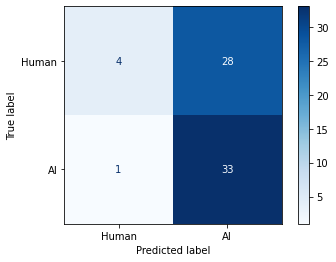

In [ ]:
nb_conf = ConfusionMatrixDisplay.from_predictions(y_test, nb_test_pred, display_labels=["Human", "AI"], cmap=plt.cm.Blues)

### Support vector machine


#### Support vector machine optimised with GridsearchCV and displayed in confusion matrix

In [ ]:
svc = SVC(random_state=42)


C = [0.01, 0.1, 1, 10, 100]
gamma = [0.00001, 0.0001, 00.1, 0.1, 1]
kernel = ['linear', 'rbf', 'poly', 'sigmoid']

param_grid = {
    "C": C,
    "gamma": gamma,
    "kernel": kernel,
}

svc_grid = GridSearchCV(svc, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
svc_grid.fit(X_train_transformed, y_train)
svc_grid_pred = svc_grid.best_estimator_.predict(X_test_transformed)

print('Accuracy score: ', round(accuracy_score(y_test, svc_grid_pred), 4))
print('F1 Score: ', round(f1_score(y_test, svc_grid_pred), 4))
print('Recall score: ', round(recall_score(y_test, svc_grid_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, svc_grid_pred), 4))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy score:  0.6667
F1 Score:  0.7027
Recall score:  0.7647
Precision Score:  0.6636


In [27]:
svc = SVC(random_state=42)


C = [1, 10, 50, 100, 200, 300, 1000]
gamma = [0.00001, 0.0001, 00.1, 0.1, 1]
kernel = ['linear', 'rbf', 'poly', 'sigmoid']

param_grid = {
    "C": C,
    "gamma": gamma,
    "kernel": kernel,
}

svc_grid = GridSearchCV(svc, param_grid=param_grid, cv=10, verbose=3)
svc_grid.fit(X_train_transformed, y_train)
svc_grid_pred = svc_grid.best_estimator_.predict(X_test_transformed)

print('Accuracy score: ', round(accuracy_score(y_test, svc_grid_pred), 4))
print('F1 Score: ', round(f1_score(y_test, svc_grid_pred), 4))
print('Recall score: ', round(recall_score(y_test, svc_grid_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, svc_grid_pred), 4))

Fitting 10 folds for each of 140 candidates, totalling 1400 fits
[CV 1/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.481 total time=   0.3s
[CV 2/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.556 total time=   0.3s
[CV 3/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.556 total time=   0.2s
[CV 4/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.556 total time=   0.2s
[CV 5/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.654 total time=   0.3s
[CV 6/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.577 total time=   0.2s
[CV 7/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.654 total time=   0.3s
[CV 8/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.615 total time=   0.2s
[CV 9/10] END ..C=1, gamma=1e-05, kernel=linear;, score=0.577 total time=   0.3s
[CV 10/10] END .C=1, gamma=1e-05, kernel=linear;, score=0.538 total time=   0.2s
[CV 1/10] END .....C=1, gamma=1e-05, kernel=rbf;, score=0.556 total time=   0.2s
[CV 2/10] END .....C=1, gamma=1e-05, kernel=

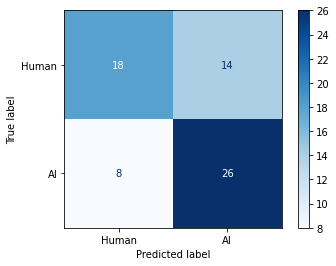

In [ ]:
conf = ConfusionMatrixDisplay.from_predictions(y_test, svc_grid_pred, display_labels=["Human", "AI"], cmap=plt.cm.Blues)

#### XGBoost classifier to compare with SVM

In [ ]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [7]:
xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=50, nthread=-1)
param_grid = {
    'colsample_bytree':[0.8],
    'max_depth': [3,4],
    'min_child_weight': [4,5],
    'subsample':[i/10.0 for i in range(6,11)],
    'gamma':[i/10.0 for i in range(3,6)],
}

xgb_grid = GridSearchCV(xgb_model, param_grid=param_grid, verbose=3, cv=10)
xgb_grid.fit(X_train_transformed, y_train)
xgb_grid_pred = xgb_grid.predict(X_test_transformed)

print('Accuracy score: ', round(accuracy_score(y_test, xgb_grid_pred), 4))
print('F1 Score: ', round(f1_score(y_test, xgb_grid_pred), 4))
print('Recall score: ', round(recall_score(y_test, xgb_grid_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, xgb_grid_pred), 4))

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10] END colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6;, score=0.963 total time=   6.2s
[CV 2/10] END colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6;, score=0.852 total time=   6.0s
[CV 3/10] END colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6;, score=0.926 total time=   5.9s
[CV 4/10] END colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6;, score=0.889 total time=   6.0s
[CV 5/10] END colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6;, score=0.923 total time=   5.9s
[CV 6/10] END colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6;, score=0.962 total time=   6.0s
[CV 7/10] END colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6;, score=0.885 total time=   6.7s
[CV 8/10] END colsample_bytree=0.8, gamma=0.3, m

In [18]:
print(xgb_grid.best_params_)

{'colsample_bytree': 0.8, 'gamma': 0.4, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9}


In [17]:
print('Accuracy score: ', round(accuracy_score(y_test, xgb_grid_pred), 4))
print('F1 Score: ', round(f1_score(y_test, xgb_grid_pred), 4))
print('Recall score: ', round(recall_score(y_test, xgb_grid_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, xgb_grid_pred), 4))

Accuracy score:  0.9242
F1 Score:  0.9315
Recall score:  1.0
Precision Score:  0.9219


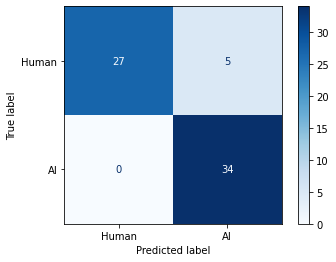

In [8]:
xgb_conf = ConfusionMatrixDisplay.from_predictions(y_test, xgb_grid_pred, display_labels=["Human", "AI"], cmap=plt.cm.Blues)

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=10, max_depth=6, max_leaves=2, min_child_weight=8)

xgb_model.fit(X_train_transformed, y_train)
xgb_pred = xgb_model.predict(X_test_transformed)

print('Accuracy score: ', round(accuracy_score(y_test, xgb_pred), 4))
print('F1 Score: ', round(f1_score(y_test, xgb_pred), 4))
print('Recall score: ', round(recall_score(y_test, xgb_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, xgb_pred), 4))

Accuracy score:  0.7576
F1 Score:  0.8
Recall score:  0.9412
Precision Score:  0.7518


#### Extra: Spacy linguistic analyses

In [ ]:
nlp = spacy.load("en_core_web_sm")

text = df_combined["content"][0]

doc = nlp(text)

token_table = []
for token in doc:
    token_table.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop])

columns = ["TEXT", "LEMMA", "POS", "TAG", "DEP", "SHAPE", "IS_ALPHA", "IS_STOP"]
token_df = pd.DataFrame(token_table, columns=columns)
token_df

,TEXT,LEMMA,POS,TAG,DEP,SHAPE,IS_ALPHA,IS_STOP
0,Shares,share,NOUN,NNS,nsubj,Xxxxx,True,False
1,in,in,ADP,IN,prep,xx,True,True
2,Europe,Europe,PROPN,NNP,poss,Xxxxx,True,False
3,'s,'s,PART,POS,case,'x,False,True
4,leading,lead,VERB,VBG,amod,xxxx,True,False
...,...,...,...,...,...,...,...,...
640,as,as,SCONJ,IN,mark,xx,True,True
641,the,the,DET,DT,det,xxx,True,True
642,bills,bill,NOUN,NNS,nsubj,xxxx,True,False
643,mounted,mount,VERB,VBD,advcl,xxxx,True,False


In [ ]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, token_df[0:50])

In [ ]:
X_test["category"].value_counts()

entertainment    14
tech             14
business         14
sport            13
politics         11
Name: category, dtype: int64

In [ ]:
df_combined["word_count"]

0      327.0
1      203.0
2      228.0
3      227.0
4      260.0
       ...  
325      NaN
326      NaN
327      NaN
328      NaN
329      NaN
Name: word_count, Length: 330, dtype: float64

#### Create classifier and display confusion matrix

In [ ]:
clf_dummy = DummyClassifier(strategy="most_frequent").fit(X_train_transformed, y_train)
pred_dummy = clf_dummy.predict(X_test_transformed)

print('Accuracy score: ', round(accuracy_score(y_test, pred_dummy), 4))
print('F1 Score: ', round(f1_score(y_test, pred_dummy), 4))
print('Recall score: ', round(recall_score(y_test, pred_dummy), 4))
print('Precision Score: ', round(roc_auc_score(y_test, pred_dummy), 4))

Accuracy score:  0.5152
F1 Score:  0.68
Recall score:  1.0
Precision Score:  0.5


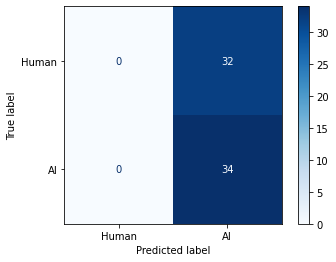

In [ ]:
confusion_matrix = ConfusionMatrixDisplay.from_estimator(clf_dummy, X_test, y_test, display_labels=["Human", "AI"], cmap=plt.cm.Blues)

#### Confusion matrix for human results

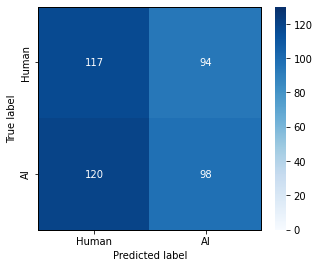

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


tp, tn, fp, fn = 98, 117, 94, 120

cm = np.zeros((2, 2))
cm[0][0] = tn
cm[0][1] = fp
cm[1][0] = fn
cm[1][1] = tp

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(cm, annot=True, ax=ax, square=True,
            cmap=plt.cm.Blues, vmin=0, vmax=130, fmt=".0f",
            xticklabels=["Human", "AI"],
            yticklabels=["Human", "AI"],
            cbar_kws={"shrink": .82})

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set(linewidth=1)

ax.set_xlabel('Predicted label', fontdict={'fontsize': 10})
ax.set_ylabel('True label', fontdict={'fontsize': 10})

plt.show()

In [7]:
def convert_to_float(tp, tn, fp, fn):
    tp = float(tp)
    tn = float(tn)
    fp = float(fp)
    fn = float(fn)
    return tp, fn, fp, fn

def acc_score():
    acc = (tp + tn)/(tp + tn + fp + fn)
    return acc

def prec_score():
    prec = tp / (tp + fp)
    return prec

def recall():
    rec = tp / (tp + fn)
    return rec

def f1_score():
    f1 = 2 * (prec_score() * recall()) / (prec_score() + recall())
    return f1

In [3]:
tp, tn, fp, fn = convert_to_float(tp, tn, fp, fn)
type(tp)

float

In [8]:
print("Accuracy score: {}".format(round(acc_score(), 4)))
print("Precision score: {}".format(round(prec_score(), 4)))
print("Recall: {}".format(round(recall(), 4)))
print("F1 score: {}".format(round(f1_score(), 4)))

Accuracy score: 0.5047
Precision score: 0.5104
Recall: 0.4558
F1 score: 0.4816
